In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook') 
sns.set_style('ticks')

#Optional, wider screen display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
def basic_timeseries_graph(data, header, x_label,y_label):
    #Graph of unemployment benefits with respect to months between 1956-1992 in Australia.
    #fig, ax = plt.subplots()
    ax = data.plot(figsize = (25,5),color = 'red')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(header)
    sns.despine()
    plt.show()

# Q1

In [3]:
#Read data
q1_temp = pd.read_excel('retail.xlsx')
#Filter column q and first row with serial number
q1_retail_time = q1_temp['Turnover ;  New South Wales ;  Other retailing n.e.c. ;'][1:].astype(float)
#Reorganize index
q1_retail_time.index = q1_retail_time.index.to_period()

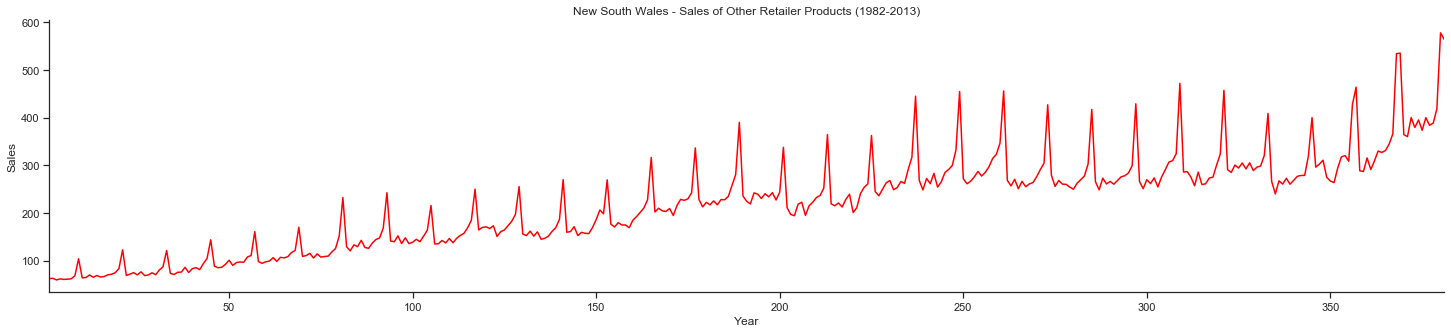

In [4]:
basic_timeseries_graph(q1_retail_time, 'New South Wales - Sales of Other Retailer Products (1982-2013)', 'Year','Sales')

#### A) Why is multiplicative seasonality necessary for this series?

The seasonality and trend is significantly observable in above graph. Moreover, 12 periods (yearly) seasonal fluctuations vary with level. 
So, we need to use multiplicative model for seasonality.Another option is to use additive model after implementing a box-cox transformation

#### B) Apply Holt-Winters’ multiplicative method to the data. Experiment with making the trend damped.

In [4]:
from scipy import stats
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import HoltWintersResults

In [5]:
fit1 = ExponentialSmoothing(q1_retail_time, seasonal_periods=12, trend='add', seasonal='mul').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(q1_retail_time, seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)

In [6]:
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","RMSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Multiplicative"] = [fit1.params[p] for p in params] + [math.sqrt(fit1.sse/q1_retail_time.count())]
results["Multiplica Dam"] = [fit2.params[p] for p in params] + [math.sqrt(fit2.sse/q1_retail_time.count())]

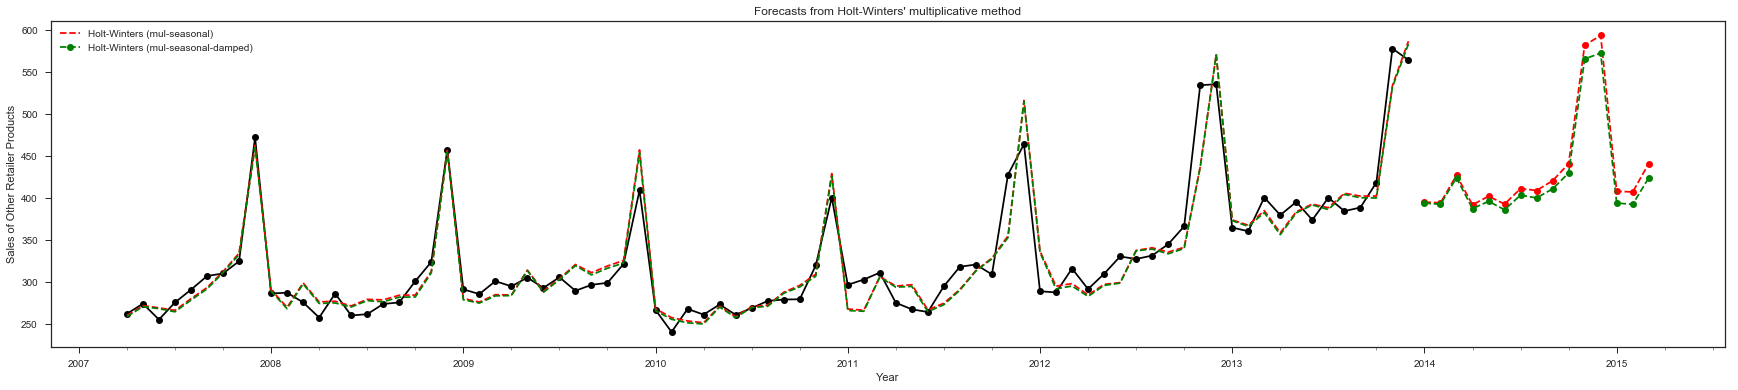

,Multiplicative,Multiplica Dam
$\alpha$,0.542,0.567
$\beta$,0.000,0.150
$\phi$,NaN,0.000
$\gamma$,0.387,0.388
$l_0$,30.011,30.012
$b_0$,0.136,0.000
RMSE,13.348,13.395


In [7]:
ax = q1_retail_time[300:].plot(figsize=(30,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("Sales of Other Retailer Products")
ax.set_xlabel("Year")
fit1.fittedvalues[300:].plot(ax=ax, style='--', color='red')
fit2.fittedvalues[300:].plot(ax=ax, style='--', color='green')

fit1.forecast(15).rename('Holt-Winters (mul-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
fit2.forecast(15).rename('Holt-Winters (mul-seasonal-damped)').plot(ax=ax, style='--', marker='o', color='green', legend=True)
plt.show()

results.round(3)

#### C) Compare the RMSE of the one-step forecasts from the two methods. Which do you prefer? Write down the mathematical equations for the preferred method.

According to results table, Holt-Winters’ multiplicative method without a dump performs better for this dataset. RMSE of choosen model is slightly lower than other.(13.348)
It is not a significant difference, one could state that for long term predictions, dumped model should be choosen. However, I will choose the first model because of lower RMSE value.
With help of the above coefficient table, our models equation is;

Mathematical equations of Holt-Winters (add-mul-seasonal-damped) model

"$\alpha$" = 0.542 
"$\beta$" = 0.0
"$\gamma$" = 0.387
h = 1
m = 12

By using these parameters with necessary L,B and S equations, we get our final equations.

#### D) Check that the residuals from the best method look like white noise

According to ACF; residuals are significantly not white noise. Lag 2,11 and 12 are in the outside of confidence interval of autocorrelations.
We now that 1/20 would be acceptable but 3 is not tolarable.
Also; histogram shows that the residual distribution is not normal.

In [8]:
resid = q1_retail_time - fit1.fittedvalues

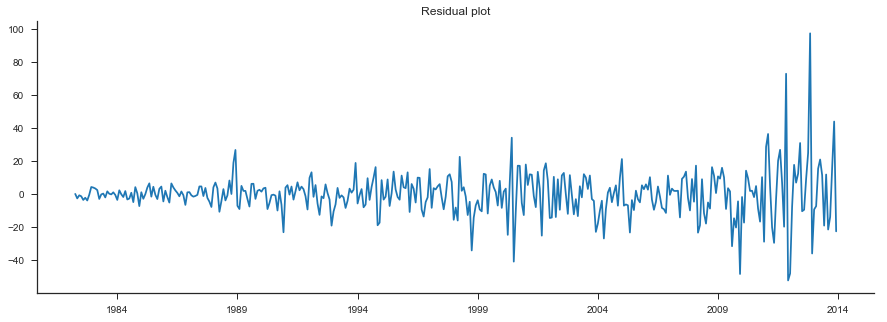

In [9]:
fig, ax= plt.subplots(figsize=(15,5))
resid.plot()
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

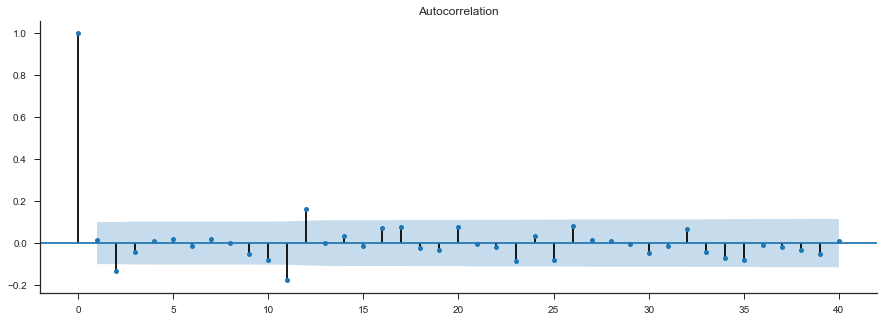

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
sm.graphics.tsa.plot_acf(resid[1:], lags=40, ax=ax)
sns.despine()
plt.show()

D:\Users\akavdir\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


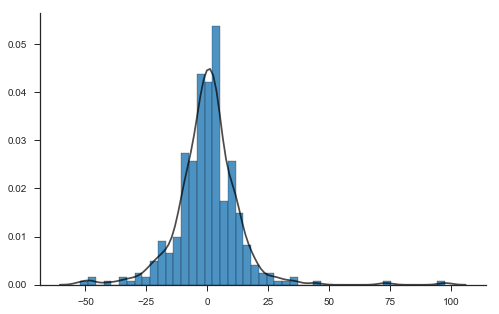

In [11]:
def hist(series):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black'},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid[1:])
plt.show()

## Q2

#### For your retail data, find the appropriate order of differencing (after transformation if necessary) to obtain stationary data.

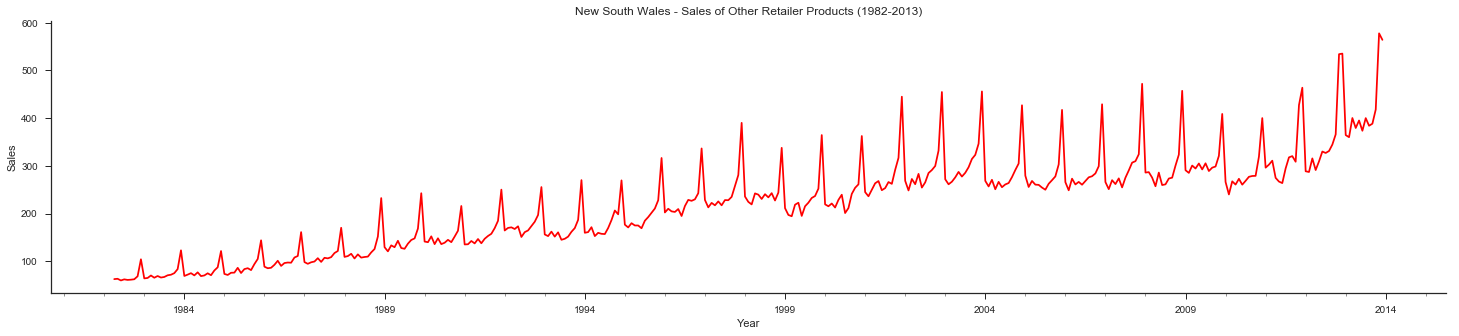

In [12]:
basic_timeseries_graph(q1_retail_time, 'New South Wales - Sales of Other Retailer Products (1982-2013)', 'Year','Sales')

As we mentioned earlier (Q1-A), "The seasonality and trend is significantly observable in above graph. Moreover, 12 periods (yearly) seasonal fluctuations vary with level. "
So, to balance that increasing magnitudes we need to implement a transformation.
We will use box-cox to find proper transformation.

In [13]:
#Box-Cox transformation
from scipy import stats
k = stats.boxcox(q1_retail_time)
print('Box-Cox Lambda: '+ str(k[1]))

Box-Cox Lambda: 0.5446735002971659


Our lambda value is very close to 0.5 which converge to square root. We would use square root transformation to easy interpretation. I tried it, and the result was not satisfactory. So, I tried log transformation and the results are belove.

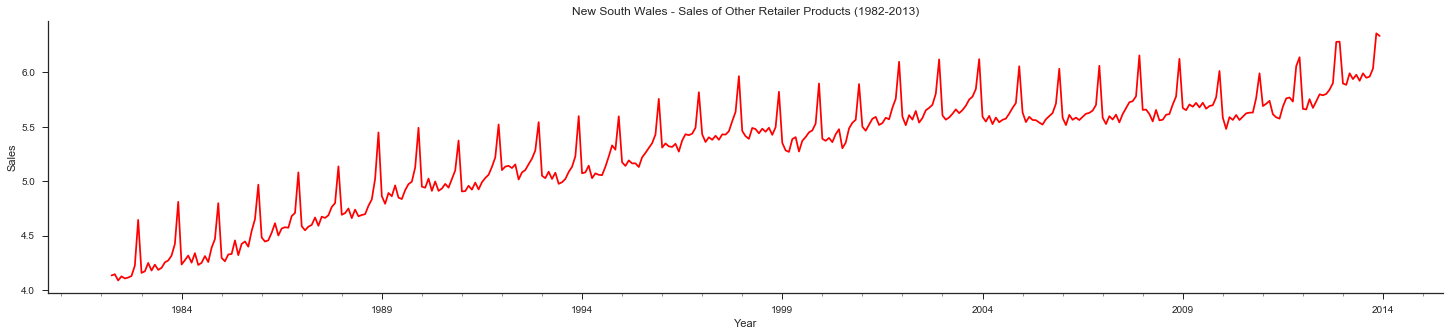

In [14]:
#Log transformation
after_log = np.log(q1_retail_time)
basic_timeseries_graph(after_log, 'New South Wales - Sales of Other Retailer Products (1982-2013)', 'Year','Sales')

After transformation we will implement seasonal differencing to clean seasonality from our data.

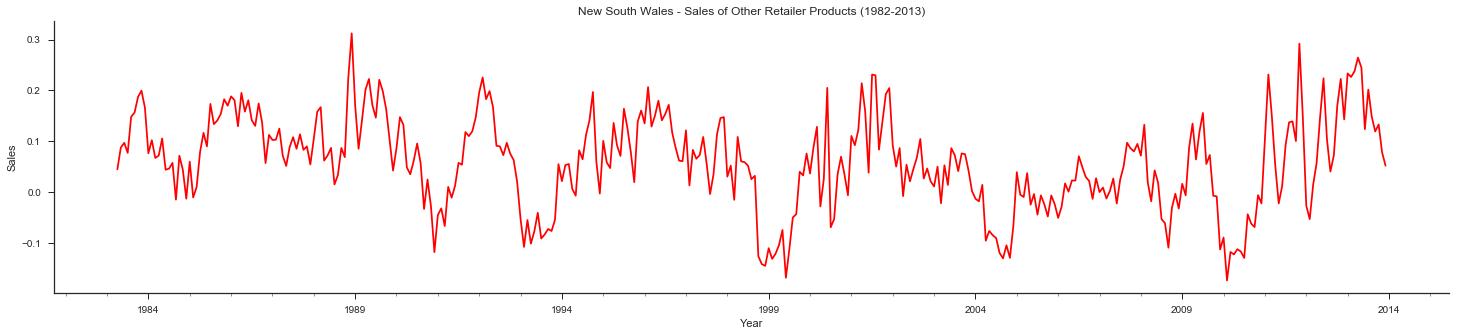

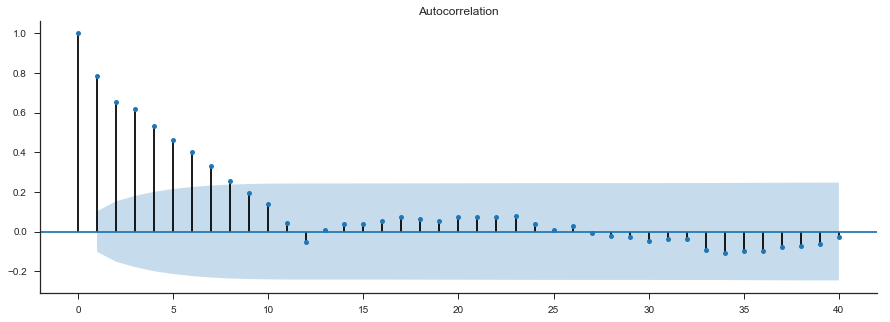

In [15]:
#12 season seasonal differencing
seasonal_diff = after_log-after_log.shift(12)
basic_timeseries_graph(seasonal_diff, 'New South Wales - Sales of Other Retailer Products (1982-2013)', 'Year','Sales')

fig, ax = plt.subplots(figsize=(15,5))
sm.graphics.tsa.plot_acf(seasonal_diff[12:], lags=40, ax=ax)
sns.despine()
plt.show()

ACF and frequency graph shows that we cleaned out seasonality but the data is still non-stationary(Smooth decrease in ACF)

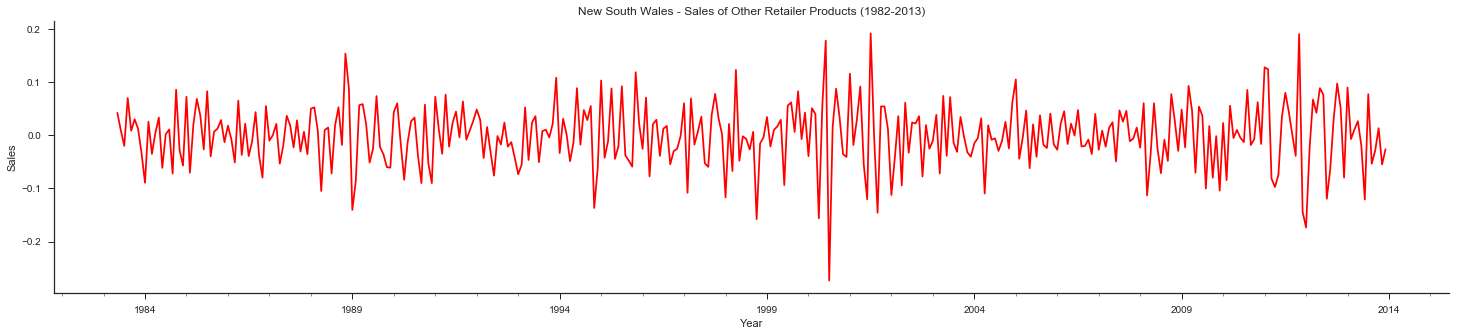

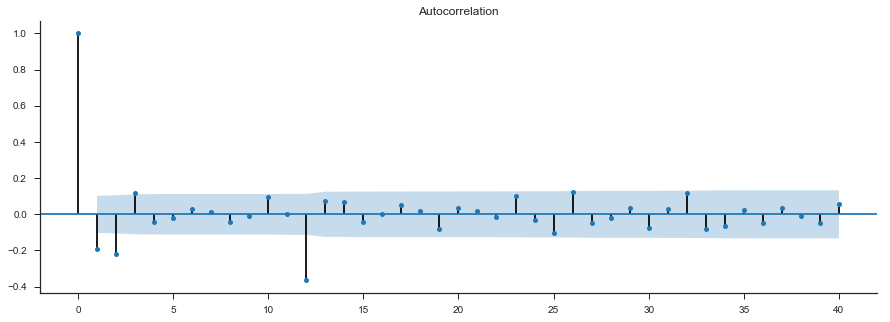

In [16]:
first_d_difference = seasonal_diff-seasonal_diff.shift(1)
basic_timeseries_graph(first_d_difference, 'New South Wales - Sales of Other Retailer Products (1982-2013)', 'Year','Sales')

fig, ax = plt.subplots(figsize=(15,5))
sm.graphics.tsa.plot_acf(first_d_difference[13:], lags=40, ax=ax)
sns.despine()
plt.show()

After first order differencing, our data cleaned out to a stationary structure.
 -  d = 1 

## Q3

In [18]:
wmurders = pd.read_csv('wmurders.csv', header = 0)
wmurders.rename(columns = {'Unnamed: 0' : 'Years', 'x' : 'Number of Murders' }, inplace = True)
wmurders.set_index('Years', inplace = True)

#### A) By studying appropriate graphs of the series in R, find an appropriate ARIMA(p,d,q) model for these data.

1st) plot the data for any unusual observations

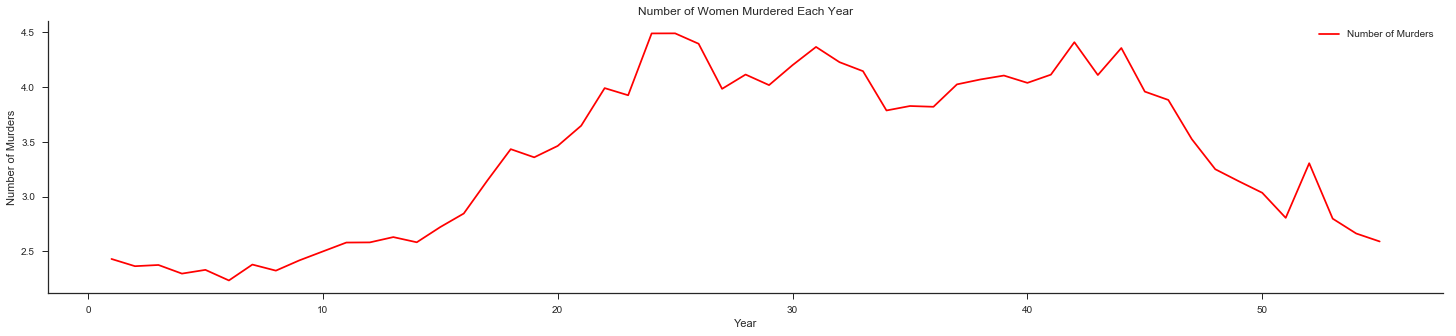

In [19]:
basic_timeseries_graph(wmurders, 'Number of Women Murdered Each Year', 'Year','Number of Murders')

2nd) transform if transformation is necessary

No variance problem has appeared, so transformation is not crucial according to graph.

3rd) Check if data is stationary. If it is not, take differences until it provide consistency.

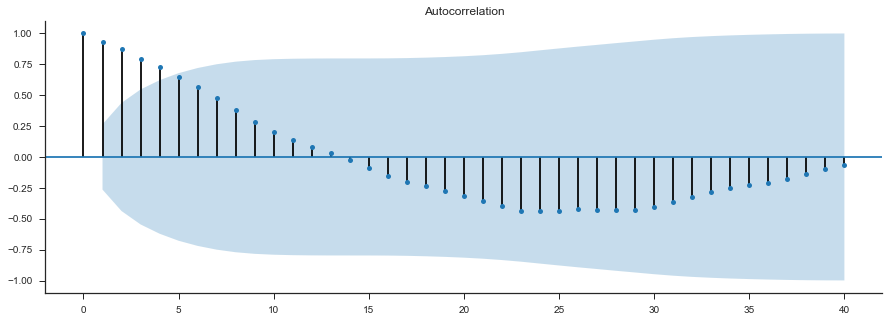

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
sm.graphics.tsa.plot_acf(wmurders, lags=40, ax=ax)
sns.despine()
plt.show()

According to ACF graph, it is obvious that the data is non-stationary.
We observed no seasonal impact so step by step first order differencing would be beneficial.
After first order difference, our data transform to stationary form.

Order of differencing (d)

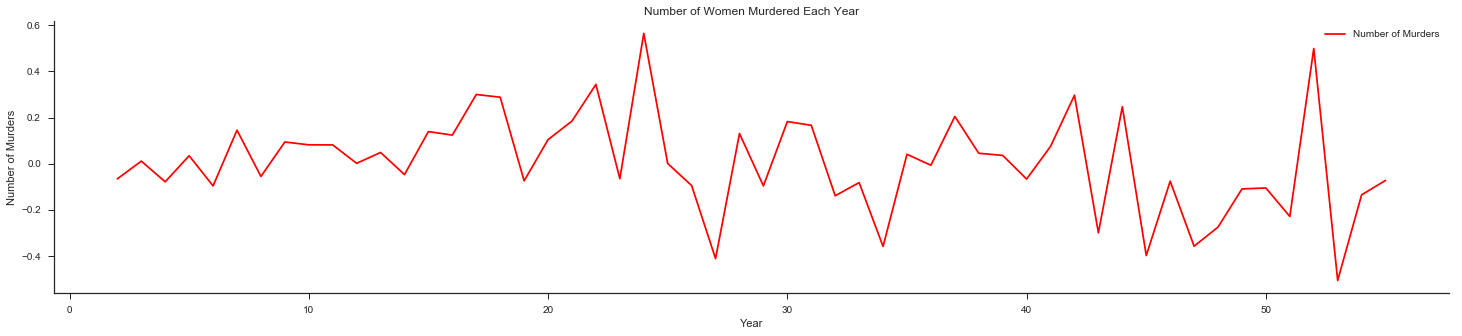

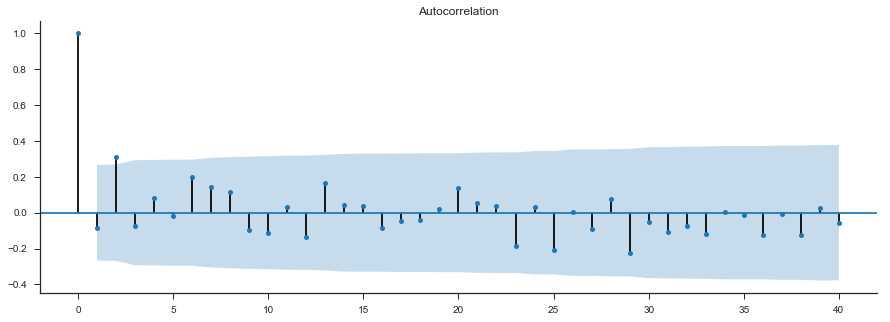

In [21]:
#Take first order difference
wmurders_1st_diff = wmurders - wmurders.shift(1)
basic_timeseries_graph(wmurders_1st_diff, 'Number of Women Murdered Each Year', 'Year','Number of Murders')

fig, ax = plt.subplots(figsize=(15,5))
sm.graphics.tsa.plot_acf(wmurders_1st_diff[1:], lags=40, ax=ax)
sns.despine()
plt.show()

4th Examine ACF/PACF to identify AR(p) and MA(q)

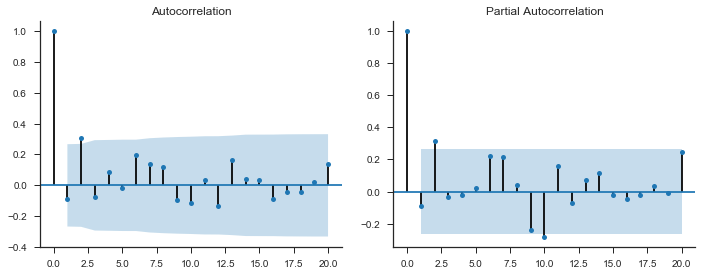

In [22]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sm.graphics.tsa.plot_acf(wmurders_1st_diff[1:], lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(wmurders_1st_diff[1:], lags=20, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

According to above ACF and PACF plots,  AR(2), MA(2) or ARMA(2,2) models could be used. 
Simplest model with lowest AICc score should be choosen,so after a few trials I decided to continue with MA(2)

#### B) Should you include a constant in the model? Explain.

A model with no orders of differencing normally includes a constant term (which allows for a non-zero mean value). 
A model with two orders of total differencing normally does not include a constant term. In a model with one order of total differencing, 
a constant term should be included if the series has a non-zero average trend. According to this source :http://people.duke.edu/~rnau/arimrule.htm
        
After first order differencing (d=1), we see a downward sloping trend which indicates a non-zero average trend.
So adding a constant would be beneficial.

#### C) Write this model in terms of the backshift operator.

(1-B)**Yt = c + (1 + $\theta$* B)

#### D) Fit the model and examine the residuals. Is the model satisfactory?

Summary:
p-values of constant and ma.L1 of our model is not satisfactory. To evaluate overall performance, a reference point is necessary.
Residuals look like white noise but normality assumption should be checked.

In [23]:
arima1 = sm.tsa.ARIMA(wmurders, order=(0, 1, 2)).fit(trend='c') 
print(arima1.summary())
print("sigma^2 is estimated as:",round(arima1.sigma2,3))
print("AICc is estimated as:",round(arima1.aic+2*(arima1.df_model+1)*(arima1.df_model+2)/(arima1.nobs-arima1.df_model-2),3))

                              ARIMA Model Results                              
Dep. Variable:     D.Number of Murders   No. Observations:                   54
Model:                  ARIMA(0, 1, 2)   Log Likelihood                   9.713
Method:                        css-mle   S.D. of innovations              0.202
Date:                 Fri, 22 May 2020   AIC                            -11.426
Time:                         23:44:27   BIC                             -3.470
Sample:                              1   HQIC                            -8.357
                                                                               
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0007      0.035      0.020      0.984      -0.069       0.070
ma.L1.D.Number of Murders    -0.0659      0.126     -0.522      0.604      -0.

D:\Users\akavdir\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Users\akavdir\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Residuals

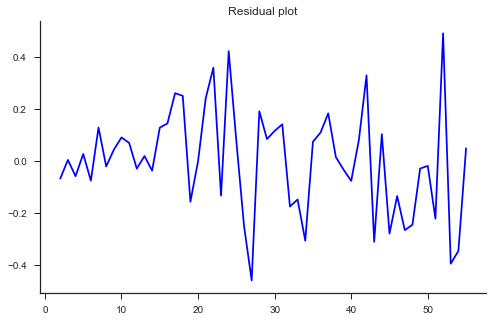

In [24]:
resid=arima1.resid
fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color='blue')
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

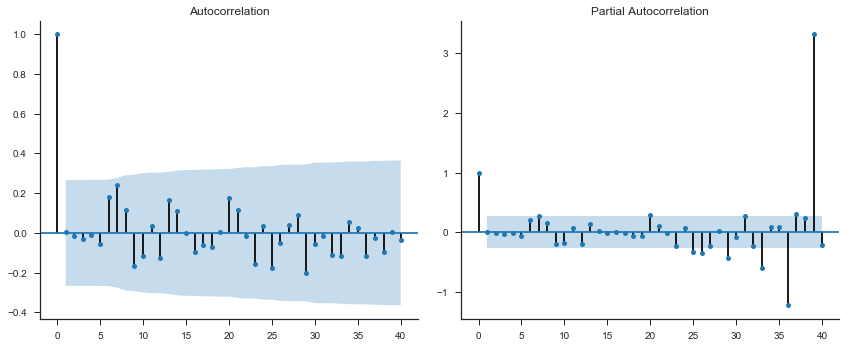

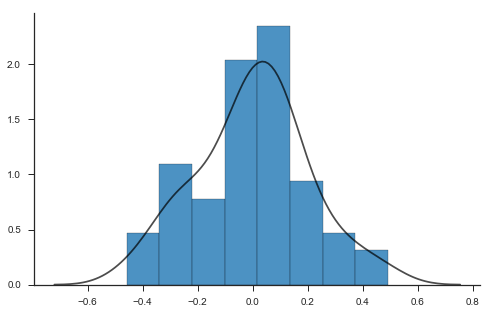

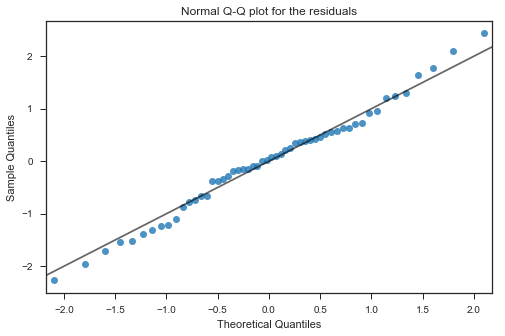

In [25]:
from forecast import histogram, qq_plot

fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()


histogram(resid)
plt.show()
qq_plot(resid)
plt.show()


In [26]:
import statsmodels.stats.diagnostic as diag
diag.acorr_ljungbox(resid, lags=24, boxpierce=False)[1][23]

0.5886453228990376

The ACF plot of the residuals from the ARIMA(0,1,2) model shows all correlations within the threshold limits indicating that the residuals are behaving like white noise.
Also according to LjungBox test, p-values are so large which indicates there is no autocorrelation between residuals.

#### E) Forecast three times ahead. Check your forecasts by hand to make sure that you know how they have been calculated.

In [27]:
arima1.forecast(steps=3)

(array([2.4590623 , 2.47820788, 2.47890852]),
 array([0.20157955, 0.2758396 , 0.38119329]),
 array([[2.06397365, 2.85415095],
        [1.9375722 , 3.01884355],
        [1.7317834 , 3.22603364]]))

To calculate these values, the difference between $\mu$ and c is important, also how python statsmodel use them.

#### F) Create a plot of the series with forecasts and prediction intervals for the next three periods shown.

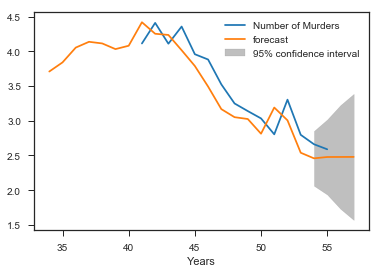

In [28]:
fig, ax = plt.subplots()
ax = wmurders[40:].plot(ax=ax)
fig = arima1.plot_predict(len(wmurders) -20, len(wmurders)+3, dynamic=False, ax=ax, plot_insample=False)
plt.show()

#### G) Does auto.arima() give the same model you have chosen? If not, which model do you think is better?

In [31]:
from statsmodels.tsa.arima_process import arma_generate_sample
from pmdarima.arima import auto_arima

arima2=auto_arima(wmurders,seasonal=False)
arima2.summary()

//anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 2, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   53
Model:                 ARIMA(0, 2, 1)   Log Likelihood                   6.129
Method:                       css-mle   S.D. of innovations              0.208
Date:                Fri, 22 May 2020   AIC                             -6.258
Time:                        23:33:53   BIC                             -0.347
Sample:                             2   HQIC                            -3.985
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.002     -2.043      0.046      -0.007      -0.000
ma.L1.D2.y    -1.0000      0.072    -13.850      0.000      -1.141      -0.858
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

No, auto_arima choose another model with lower AIC score and few number of features. So, auto_arima model is better

## Q3

In [29]:
aus_tourists = pd.read_csv('austourists.csv')
aus_tourists.rename(columns = {'Unnamed: 0' : 'Years', 'x' : 'Number of Tourists' }, inplace = True)
aus_tourists.set_index('Years', inplace = True)

#### A) Describe the time plot.

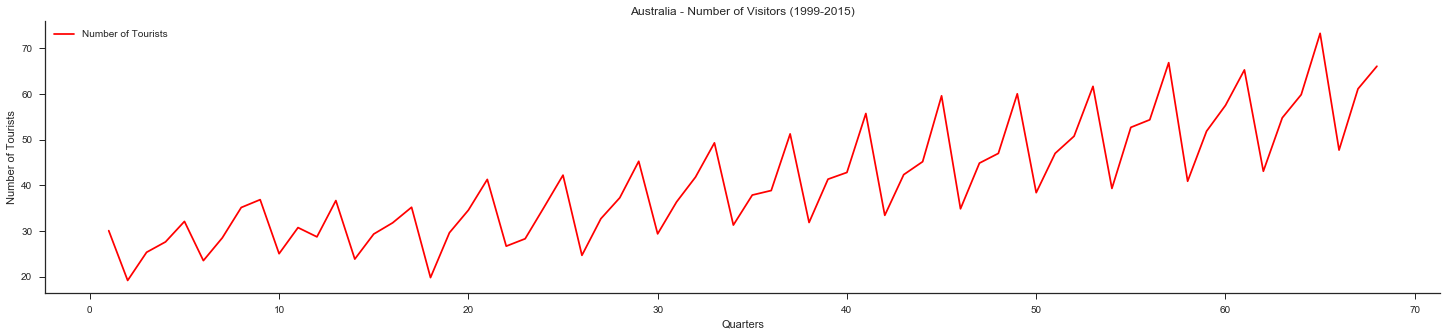

In [30]:
basic_timeseries_graph(aus_tourists, 'Australia - Number of Visitors (1999-2015)', 'Quarters','Number of Tourists')

The seasonality and trend are significantly observable in above graph. Moreover, 4 periods (quarterly) seasonal fluctuations vary with level.
So, implementation of a seasonal treatment is necessary.

#### B) What can you learn from the ACF graph?

ACF indicates that a significant seasonality exists and taking 4th order difference should clean it out. 
So, another differencing would be beneficial.

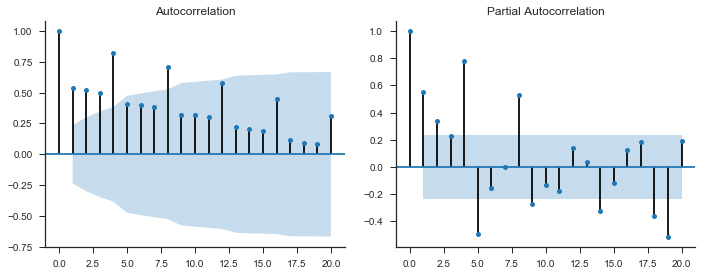

In [31]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sm.graphics.tsa.plot_acf(aus_tourists, lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(aus_tourists, lags=20, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

#### C) What can you learn from the PACF graph?

"We find optimum features or order of the AR process using the PACF plot, as it removes variations explained by earlier lags so we get only the relevant features."

According to PCDF, there is a seasonality with 4 lags.
Moreover, most of the autocorrelation that ACF shows comes from 3 recent months, but prior months also consist of a certain degree of negative autocorrelation.
So, another differencing would be beneficial.

#### D) Produce plots of the seasonally differenced data (1−B4)Yt. What model do these graphs suggest?

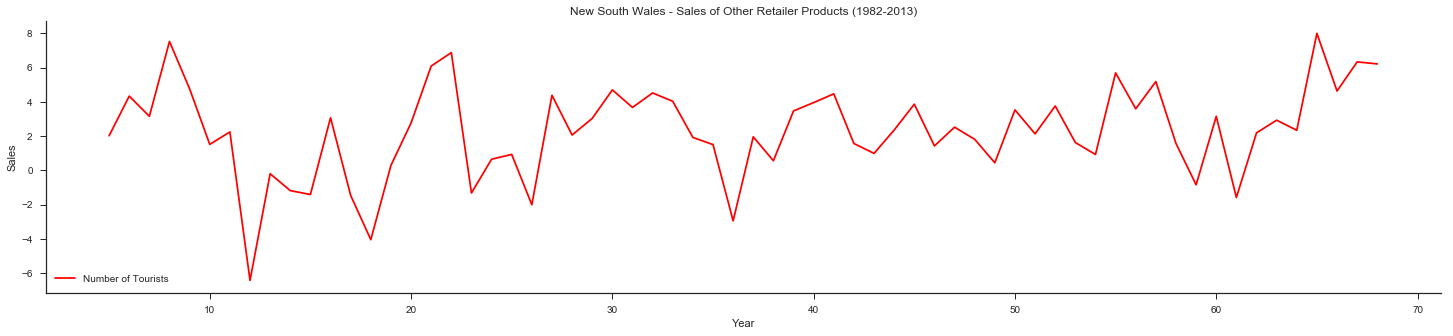

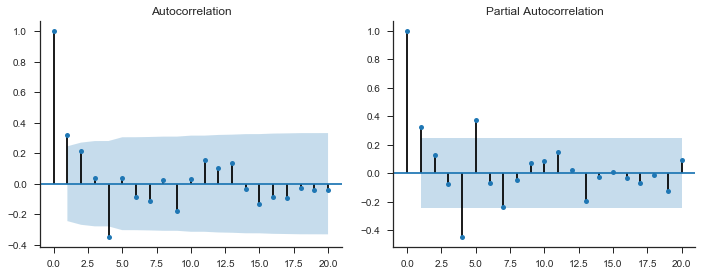

In [32]:
#12 season seasonal differencing
seasonal_4diff = aus_tourists-aus_tourists.shift(4)
basic_timeseries_graph(seasonal_4diff, 'New South Wales - Sales of Other Retailer Products (1982-2013)', 'Year','Sales')

fig, ax = plt.subplots(1,2, figsize=(10,4))
sm.graphics.tsa.plot_acf(seasonal_4diff[4:], lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(seasonal_4diff[4:], lags=20, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

There is still evidence of autocorrelation between time series, first order difference would be beneficial.

First order difference after seasoanal differencing

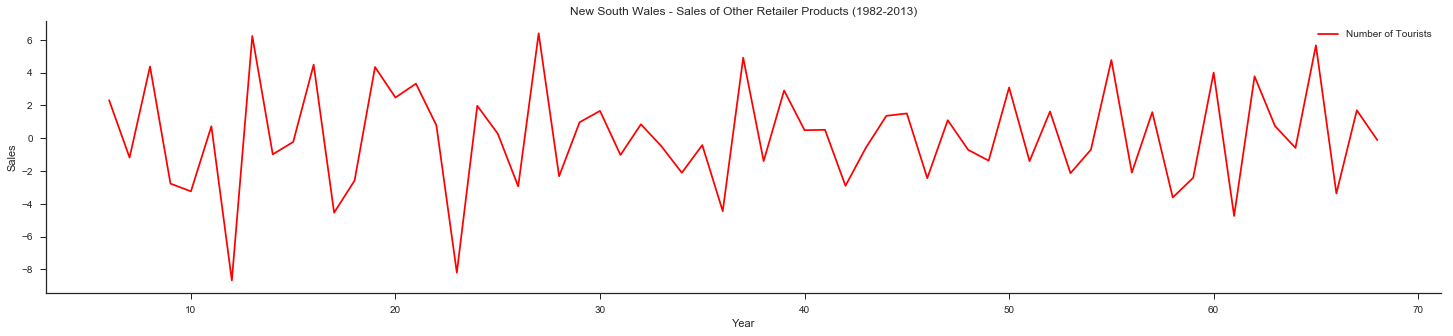

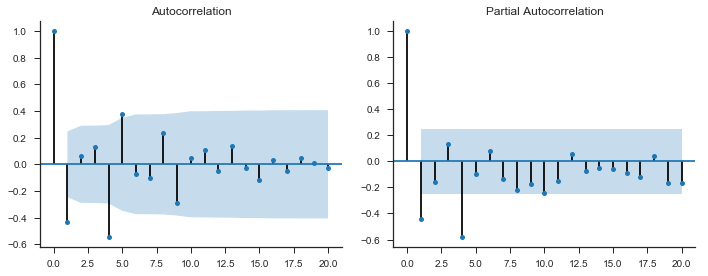

In [33]:
seasonal_diff_aus =  seasonal_4diff-seasonal_4diff.shift(1)
basic_timeseries_graph(seasonal_diff_aus, 'New South Wales - Sales of Other Retailer Products (1982-2013)', 'Year','Sales')

fig, ax = plt.subplots(1,2, figsize=(10,4))
sm.graphics.tsa.plot_acf(seasonal_diff_aus[5:], lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(seasonal_diff_aus[5:], lags=20, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

After seasonal and first order differencing, according to ACF and PACF graphs we should use a ARMA(4,5) but this model would be so complicated, so I will try several combinations

#### E) Does auto.arima() give the same model that you chose? If not, which model do you think is better?

My model

In [34]:
arima1 = sm.tsa.SARIMAX(aus_tourists, order=(4, 1, 5), seasonal_order=(1, 1, 1, 4)).fit(trend='nc')
arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                Number of Tourists   No. Observations:                   68
Model:             SARIMAX(4, 1, 5)x(1, 1, 1, 4)   Log Likelihood                -138.421
Date:                           Fri, 22 May 2020   AIC                            300.842
Time:                                   23:46:44   BIC                            326.560
Sample:                                        0   HQIC                           310.957
                                            - 68                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0940      0.182      0.517      0.605      -0.262       0.450
ar.L2          0.4191      0.196      2.134      0.033       0.034       0.804
ar.L3          0.5102      0.204      2.506      0.012       0.111       0.909
ar.L4         -0.4595      0.198     -2.319      0.020      -0.848      -0.071
ma.L1         -0.6778      0.297     -2.279      0.023      -1.261      -0.095
ma.L2         -0.4348      0.346     -1.256      0.209      -1.113       0.244
ma.L3         -0.5196      0.195     -2.661      0.008      -0.902      -0.137
ma.L4          0.3428      0.249      1.379      0.168      -0.144       0.830
ma.L5          0.3337      0.225      1.481      0.139      -0.108       0.775
ar.S.L4       -0.9407      0.855     -1.101      0.271      -2.616       0.734
ma.S.L4        0.9830      1.191      0.825      0.409      -1.351       3.317
sigma2         4.3871      2.272      1.931      0.053      -0.065       8.839
===================================================================================
Ljung-Box (Q):                       23.58   Jarque-Bera (JB):                 5.71
Prob(Q):                              0.98   Prob(JB):                         0.06
Heteroskedasticity (H):               0.39   Skew:                            -0.64
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Auto-arima

In [46]:
arima2=auto_arima(aus_tourists,seasonal=True)
arima2.summary()

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   68
Model:               SARIMAX(3, 1, 4)   Log Likelihood                -154.850
Date:                Fri, 22 May 2020   AIC                            327.699
Time:                        23:38:54   BIC                            347.542
Sample:                             0   HQIC                           335.551
                                 - 68                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.2935      0.475      4.832      0.000       1.363       3.224
ar.L1         -0.9967      0.027    -36.788      0.000      -1.050      -0.944
ar.L2         -1.0027      0.019    -53.413      0.000      -1.039      -0.966
ar.L3         -0.9901      0.016    -61.210      0.000      -1.022      -0.958
ma.L1          0.3569      0.205      1.739      0.082      -0.045       0.759
ma.L2          0.3804      0.155      2.456      0.014       0.077       0.684
ma.L3          0.1017      0.147      0.690      0.490      -0.187       0.391
ma.L4         -0.3125      0.159     -1.967      0.049      -0.624      -0.001
sigma2         4.9299      0.948      5.199      0.000       3.071       6.788
===================================================================================
Ljung-Box (Q):                       36.52   Jarque-Bera (JB):                 6.40
Prob(Q):                              0.63   Prob(JB):                         0.04
Heteroskedasticity (H):               0.49   Skew:                            -0.68
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
I understand that auto_arima model is simpler and I am not using AICc for comparison but according to AIC scores, my seasonal ARIMA model performs better.
So I choose first model.

#### F) Write the model in terms of the backshift operator, then without using the backshift operator.

(1 − φB...-φB^4)(1 − ΦB^4 )(1 − B)(1 − B^4)yt = (1 + θB...+θB^5)(1 + Θ1B^4)et